# Image Generation Prompt iteration

This is based off of a tweet from [@ThorondorLLC](https://x.com/ThorondorLLC)

Tweet is [here](https://x.com/ThorondorLLC/status/1880048546382221313)

This will take an initial desired prompt, and iteratively refine it until the image generated matches the desired prompt.

This is not DSPy prompt optimization as it is normally used, but it is a good example of how to use multimodal DSPy.

A future upgrade would be to create a dataset of initial, final prompts to optimize the prompt generation.

You can install DSPy via:
```bash
pip install -U dspy
```

For this example, we'll use Flux Pro from FAL. You can get an API key [here](https://fal.com/flux-pro)

We will also need to install Pillow and dotenv.
```bash
pip install fal-client pillow dotenv
```


Now, let's import the necessary libraries and set up the environment:

In [ ]:
# Optional
#os.environ["FAL_API_KEY"] = "your_fal_api_key"
#os.environ["OPENAI_API_KEY"] = "your_openai_api_key"

In [1]:
import dspy

from PIL import Image
from io import BytesIO
import requests
import fal_client

from dotenv import load_dotenv
load_dotenv()

# import display
from IPython.display import display

lm = dspy.LM(model="gpt-4o-mini", temperature=0.5)
dspy.configure(lm=lm)

/Users/isaac/sd_optimizer/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)
/Users/isaac/sd_optimizer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def generate_image(prompt):

    request_id = fal_client.submit(
        "fal-ai/flux-pro/v1.1-ultra",
        arguments={
            "prompt": prompt
        },
    ).request_id

    result = fal_client.result("fal-ai/flux-pro/v1.1-ultra", request_id)
    url = result["images"][0]["url"]

    return dspy.Image.from_url(url)

def display_image(image):
    url = image.url
    # download the image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # display at 25% of original size
    display(image.resize((image.width // 4, image.height // 4)))


Iteration 1 of 5


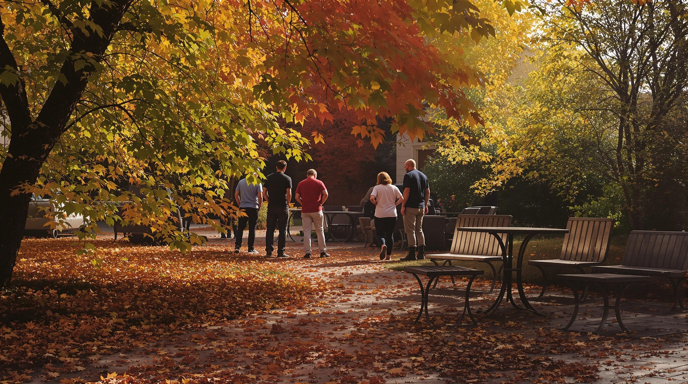

Feedback: The image depicts a peaceful autumn scene with people walking among colorful leaves, which aligns with the peaceful aspect of the prompt. However, it lacks any elements that convey tension, making it not fully representative of the desired prompt.
Iteration 2 of 5


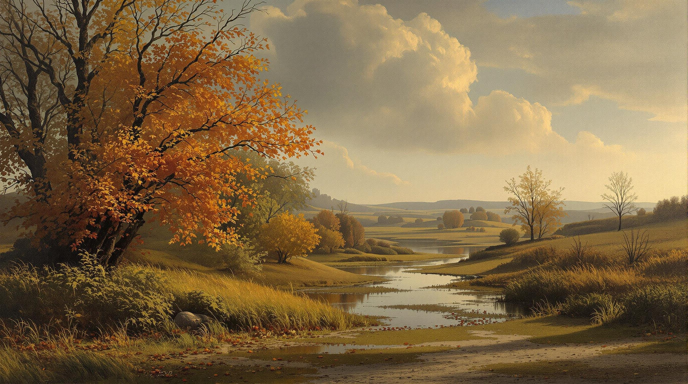

Feedback: The image depicts a serene autumn scene with vibrant foliage and a calm river, which aligns well with the idea of peace. However, it lacks explicit elements that suggest underlying tension, making it less effective in conveying both aspects of the desired prompt.
Iteration 3 of 5


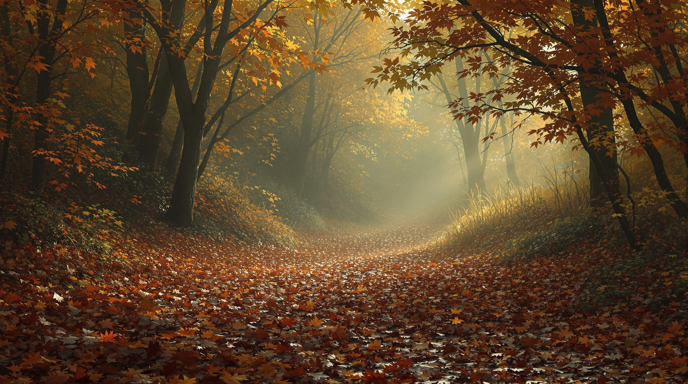

Feedback: The image depicts a serene autumn scene with warm colors and soft lighting, which aligns with the peaceful aspect of the desired prompt. However, it lacks elements that evoke tension or unease, making it not fully meet the requirement for a scene that is both peaceful and tense.
Iteration 4 of 5


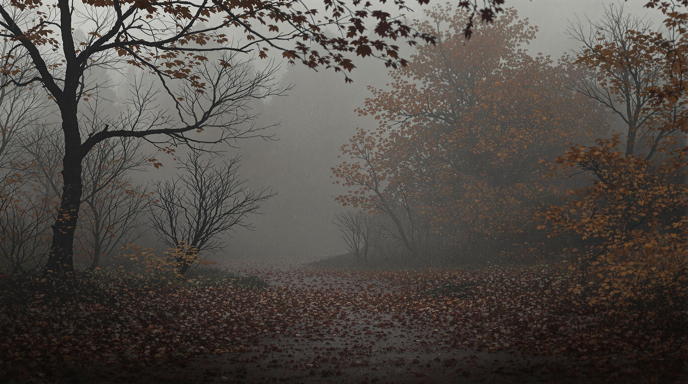

Final prompt: A serene autumn scene with fog and shadows, capturing both peace and tension.


In [18]:
check_and_revise_prompt = dspy.Predict("desired_prompt: str, current_image: dspy.Image, current_prompt:str -> feedback:str, image_strictly_matches_desired_prompt: bool, revised_prompt: str")

initial_prompt = "A scene that's both peaceful and tense"
current_prompt = initial_prompt

max_iter = 5
for i in range(max_iter):
    print(f"Iteration {i+1} of {max_iter}")
    current_image = generate_image(current_prompt)
    result = check_and_revise_prompt(desired_prompt=initial_prompt, current_image=current_image, current_prompt=current_prompt)
    display_image(current_image)
    if result.image_strictly_matches_desired_prompt:
        break
    else:
        current_prompt = result.revised_prompt
        print(f"Feedback: {result.feedback}")
        print(f"Revised prompt: {result.revised_prompt}")

print(f"Final prompt: {current_prompt}")


In [19]:
dspy.inspect_history(5)





[2025-01-17T11:36:55.947579]

System message:

Your input fields are:
1. `desired_prompt` (str)
2. `current_image` (Image)
3. `current_prompt` (str)

Your output fields are:
1. `feedback` (str)
2. `revised_prompt` (str)
3. `image_strictly_matches_desired_prompt` (bool)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## desired_prompt ## ]]
{desired_prompt}

[[ ## current_image ## ]]
{current_image}

[[ ## current_prompt ## ]]
{current_prompt}

[[ ## feedback ## ]]
{feedback}

[[ ## revised_prompt ## ]]
{revised_prompt}

[[ ## image_strictly_matches_desired_prompt ## ]]
{image_strictly_matches_desired_prompt}        # note: the value you produce must be True or False

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `desired_prompt`, `current_image`, `current_prompt`, produce the fields `feedback`, `revised_prompt`, `image_strictly_matches_desired_prompt`.


User message:

[[ ## d